## Описание задачи:
Есть данные о такси-компании, которая хочет изучить отток водителей и посмотреть, какие есть различия между водителями, которые покидают сервис, и которые остаются. Нужно сформулировать и протестировать гипотезы, выделить группы водителей, которые наиболее подвержены "оттоку". На основе результатов сделать выводы о том, что можно улучшить в сервисе, чтобы в дальнейшем внести изменения (и после – провести A/B тест и выяснить, стало ли лучше).

### Описание данных

- `city` – город
- `phone` – основное устройство, которое использует водитель 
- `signup_date` – дата регистрации аккаунта (`YYYYMMDD`)
- `last_trip_date` – дата последней поездки (`YYYYMMDD`)
- `avg_dist` – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации
- `avg_rating_by_driver` – средняя оценка поездок водителем 
- `avg_rating_of_driver` – средняя оценка поездок водителя
- `surge_pct` – процент поездок, совершенных с множителем > 1 (кажется когда большая загруженность и тд)
- `avg_surge` – средний множитель всплеска за все поездки этого водителя
- `trips_in_first_30_days` – количество поездок, которые совершил водитель в первые 30 дней после регистрации
- `luxury_car_user` – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль
- `weekday_pct` – процент поездок пользователя, совершенных в будние дни


### Ход исследования

1. Препроцессинг & знакомство с данными
2. Формулировка и проверка гипотез
3. Выводы

## 1. Препроцессинг & знакомство с данными

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss

import requests
from urllib.parse import urlencode

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/txV5H_GvOjEsIA'

# загрузочная ссылка
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# файл и его сохранение
download_response = requests.get(download_url)
with open('churn.csv', 'wb') as f: 
    f.write(download_response.content)

In [3]:
df = pd.read_csv('churn.csv')

In [4]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   avg_dist                50000 non-null  float64
 1   avg_rating_by_driver    49799 non-null  float64
 2   avg_rating_of_driver    41878 non-null  float64
 3   avg_surge               50000 non-null  float64
 4   city                    50000 non-null  object 
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   signup_date             50000 non-null  object 
 8   surge_pct               50000 non-null  float64
 9   trips_in_first_30_days  50000 non-null  int64  
 10  luxury_car_user         50000 non-null  bool   
 11  weekday_pct             50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Изменяем тип для дат:


In [6]:
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   avg_dist                50000 non-null  float64       
 1   avg_rating_by_driver    49799 non-null  float64       
 2   avg_rating_of_driver    41878 non-null  float64       
 3   avg_surge               50000 non-null  float64       
 4   city                    50000 non-null  object        
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   signup_date             50000 non-null  datetime64[ns]
 8   surge_pct               50000 non-null  float64       
 9   trips_in_first_30_days  50000 non-null  int64         
 10  luxury_car_user         50000 non-null  bool          
 11  weekday_pct             50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

## 2. Формулировка гипотез

Создаем лейбл churn – пользователь ушел, если не был активен последние 30 дней 

In [8]:
# максимальная дата последней поездки
df.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [9]:
# количество дней с последней поездки
df['days_since_last_trip'] = (df.last_trip_date.max() - df.last_trip_date).dt.days

In [10]:
# отток - если последняя поездка была больше 30 дней назад
df['churn'] = df.days_since_last_trip.apply(lambda x: 'churn' if x > 30 else 'not_churn')
df[['days_since_last_trip', 'churn']]

,days_since_last_trip,churn
0,14,not_churn
1,57,churn
2,175,churn
3,2,not_churn
4,108,churn
...,...,...
49995,26,not_churn
49996,157,churn
49997,40,churn
49998,167,churn


### Гипотеза 1: проблема может быть среди юзеров на конкретной платформе

Очень много пользователей не использовали сервис в последнем месяце. Нужно разобраться, какие факторы могут влиять на отток водителей

In [11]:
df.churn.value_counts(normalize=True).mul(100)

churn
churn        62.392
not_churn    37.608
Name: proportion, dtype: float64

In [12]:
pd.crosstab(df.churn, df.phone)

phone,Android,iPhone
churn,,
churn,11876,19057
not_churn,3146,15525


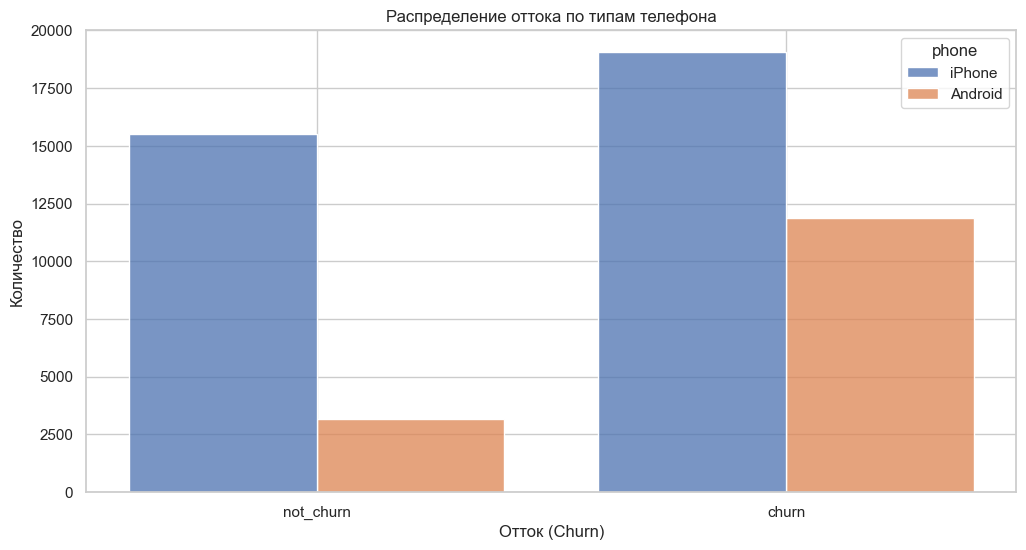

In [13]:
# гистограмма
sns.histplot(data=df[['churn', 'phone']].dropna(), 
             x='churn', 
             hue='phone', 
             multiple='dodge', 
             shrink=0.8)

# заголовок и подписи
plt.title('Распределение оттока по типам телефона')
plt.xlabel('Отток (Churn)')
plt.ylabel('Количество')

plt.show()

Проверим гипотезу с помощью статистического теста.

Есть две категориальные переменные → нужен хи-квадрат

- $H_0$: взаимосвязи между оттоком и типом платформы нет 
- $H_1$: взаимосвязь между оттоком и типом платформы есть

In [14]:
stat, p, dof, expected = ss.chi2_contingency(pd.crosstab(df.churn, df.phone))

In [15]:
stat, p

(np.float64(2558.394212267425), np.float64(0.0))

In [16]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Нулевая гипотеза отклоняется (p <= 0.05), взаимосвязь между оттоком и платформой есть.')
else:
    print('Не отклоняем нулевую гипотезу (p > 0.05), взаимосвязи между оттоком и платформой нет.')

Нулевая гипотеза отклоняется (p <= 0.05), взаимосвязь между оттоком и платформой есть.


### Гипотеза 2: проблема может зависеть от города 

- $H_0$: взаимосвязи между городом и оттоком нет 
- $H_1$: взаимосвязь между городом и оттоком есть

In [17]:
pd.crosstab(df.churn, df.city)

city,Astapor,King's Landing,Winterfell
churn,,,
churn,12306,3767,15123
not_churn,4228,6363,8213


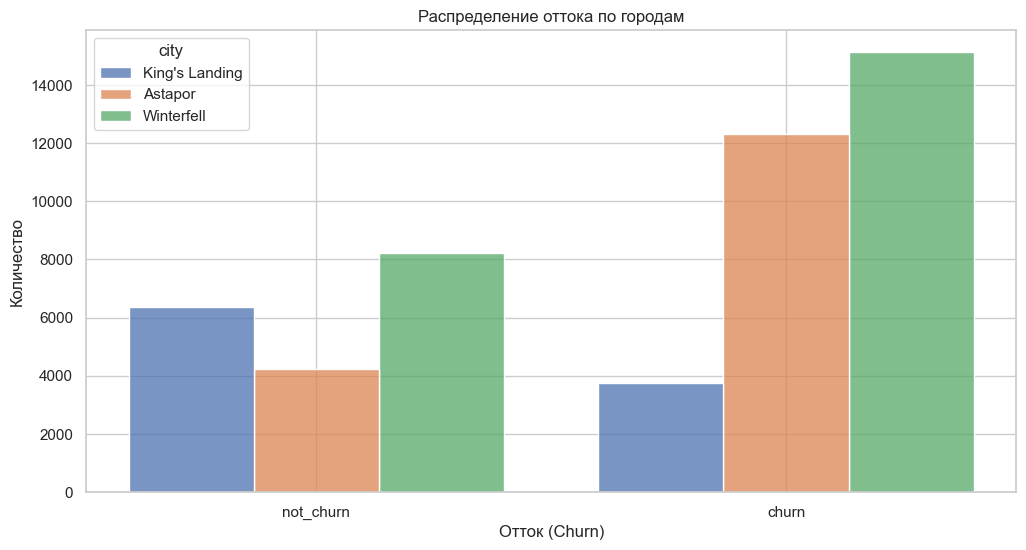

In [18]:
# гистограмма
sns.histplot(data=df[['churn', 'city']].dropna(), 
             x='churn', 
             hue='city', 
             multiple='dodge', 
             shrink=0.8)

# заголовок и подписи
plt.title('Распределение оттока по городам')
plt.xlabel('Отток (Churn)')
plt.ylabel('Количество')

plt.show()

In [19]:
stat, p, dof, expected = ss.chi2_contingency(pd.crosstab(df.churn, df.city))

In [20]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Нулевая гипотеза отклоняется (p <= 0.05), взаимосвязь между оттоком и городом есть.')
else:
    print('Не отклоняем нулевую гипотезу (p > 0.05), взаимосвязи между оттоком и городом нет.')

Нулевая гипотеза отклоняется (p <= 0.05), взаимосвязь между оттоком и городом есть.


### Гипотеза 3: существует разница в активности в первые 30 дней с момента регистрации между водителями из разных городов

- $H_0$: взаимосвязи между активностью пользователей и городом нет
- $H_1$: взаимосвязь между активностью пользователей и городом есть

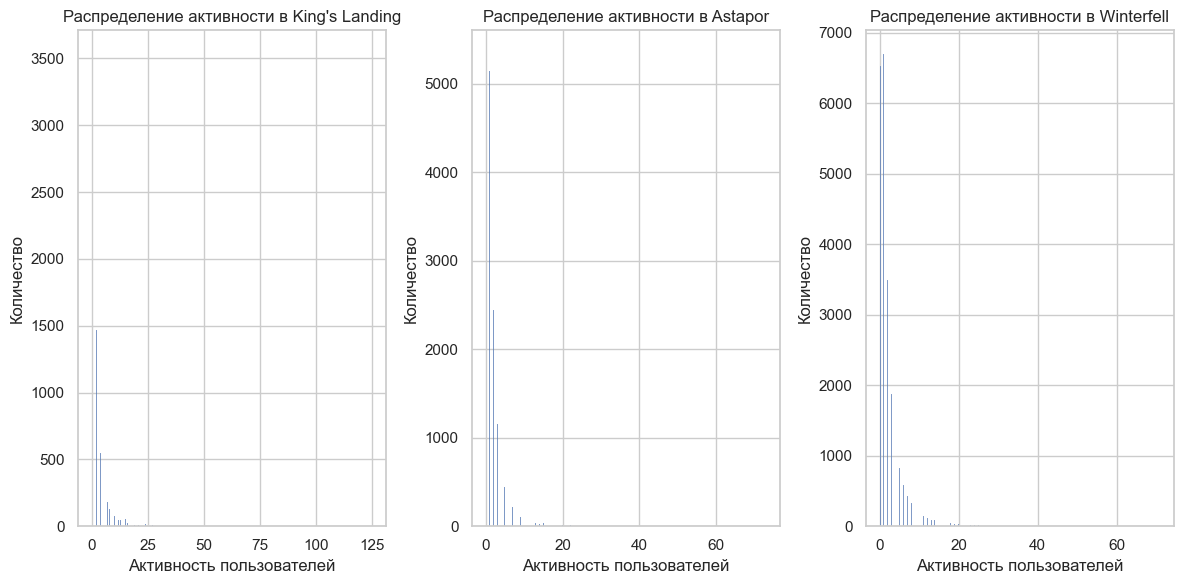

In [21]:
# создаем фигуру с тремя сабплотами (1 строка, 3 столбца)
fig, axes = plt.subplots(nrows=1, ncols=3)

# график для King's Landing
sns.histplot(
    data=df[df['city'] == "King's Landing"], 
    x='trips_in_first_30_days', 
    shrink=0.8,
    ax=axes[0] 
)
axes[0].set_title("Распределение активности в King's Landing")
axes[0].set_xlabel('Активность пользователей')
axes[0].set_ylabel('Количество')

# график для Astapor
sns.histplot(
    data=df[df['city'] == "Astapor"], 
    x='trips_in_first_30_days', 
    shrink=0.8,
    ax=axes[1]  
)
axes[1].set_title("Распределение активности в Astapor")
axes[1].set_xlabel('Активность пользователей')
axes[1].set_ylabel('Количество')

# график для Winterfell
sns.histplot(
    data=df[df['city'] == "Winterfell"], 
    x='trips_in_first_30_days', 
    shrink=0.8,
    ax=axes[2]  
)
axes[2].set_title("Распределение активности в Winterfell")
axes[2].set_xlabel('Активность пользователей')
axes[2].set_ylabel('Количество')


plt.tight_layout()
plt.show()

Распределения не являются нормальными, поэтому для проверки гипотезы применим непараметрический критерий Краскала-Уоллеса

In [22]:
df_king = df[df['city'] == "King's Landing"]['trips_in_first_30_days']
df_astar = df[df['city'] == "Astapor"]['trips_in_first_30_days']
df_winter = df[df['city'] == "Winterfell"]['trips_in_first_30_days']

In [23]:
stats, p = ss.kruskal(df_king, df_astar, df_winter)

In [24]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Нулевая гипотеза отклоняется (p <= 0.05), взаимосвязь между активностью пользователей и городом есть.')
else:
    print('Не отклоняем нулевую гипотезу (p > 0.05), взаимосвязи между активностью пользователей и городом нет.')

Нулевая гипотеза отклоняется (p <= 0.05), взаимосвязь между активностью пользователей и городом есть.


### Гипотеза 4: может существовать взаимосвязь между оттоком и активностью пользователей в первые 30 дней.

- $H_0$: взаимосвязи между активностью пользователей и оттоком нет
- $H_1$: взаимосвязь между активностью пользователей и отокком есть

In [25]:
df_churn = df[df['churn'] == 'churn']
df_no_churn = df[df['churn'] == 'not_churn']

In [26]:
stats, p = ss.mannwhitneyu(df_churn['trips_in_first_30_days'], df_no_churn['trips_in_first_30_days'])

In [27]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Нулевая гипотеза отклоняется (p <= 0.05), взаимосвязь между активностью пользователей и оттоком есть.')
else:
    print('Не отклоняем нулевую гипотезу (p > 0.05), взаимосвязи между активностью пользователей и оттоком нет.')

Нулевая гипотеза отклоняется (p <= 0.05), взаимосвязь между активностью пользователей и оттоком есть.


## Выводы

В ходе анализа данных такси-компании были проверены несколько гипотез, касающихся факторов, влияющих на отток водителей. По итогам тестирования гипотез выявлены следующие закономерности:
1. Платформа телефона водителя влияет на отток.
   Это может быть связано с техническими особенностями работы приложения.
2. Отток водителей зависит от города.
   Водители в разных городах по-разному взаимодействуют с сервисом, что может быть связано с особенностями инфраструктуры, спроса на поездки или конкурентной среды.
3. Активность в первые 30 дней различается в зависимости от города.
   Это подтверждает, что условия работы водителей существенно варьируются в зависимости от региона, что может требовать индивидуального подхода к удержанию водителей в разных городах.
4. Отток связан с активностью водителей в первые 30 дней.
   Водители, которые активно выполняют поездки в первый месяц после регистрации, с меньшей вероятностью покидают сервис. Это означает, что ранняя вовлеченность играет ключевую роль в удержании пользователей.

Рекомендации по улучшению сервиса:
1. Оптимизировать приложение под разные платформы, чтобы минимизировать технические проблемы, которые могут способствовать оттоку.
2. Разработать индивидуальные стратегии привлечения и удержания водителей в зависимости от города.
3. Внедрить программы стимулирования активности в первые 30 дней, например, бонусы за выполнение определенного числа поездок в первый месяц.
4. Провести A/B тестирование предложенных изменений, чтобы оценить их влияние на снижение оттока водителей.

Дальнейший анализ может включать более детальное изучение факторов, влияющих на раннюю активность водителей, а также дополнительную сегментацию пользователей для более точного таргетинга мер по удержанию.